<a href="https://colab.research.google.com/github/Alafiade/Structured-Pruning-on-a-ResNet-50-model/blob/main/Structured_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING DEPENDENCIES

In [1]:


!pip install split-folders
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
plt.ion()
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import splitfolders
import torch.utils.data as data


DATA AQUISITION

In [2]:

!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
 78% 17.0M/21.8M [00:00<00:00, 84.8MB/s]
100% 21.8M/21.8M [00:00<00:00, 90.4MB/s]


In [3]:
!unzip satellite.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  infl

DATA PREPROCESSING

In [4]:
!pip install split-folders # Install splitfolders using pip
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.utils.data as data
import splitfolders # Import splitfolders


# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Define data directories
data_dir = "/content/data"  # Replace with the actual path to your data directory
output_dir = "/content/sample_data" # Define output directory for split data

# Split the data into train and val sets using splitfolders
# This will create 'train' and 'val' directories inside output_dir
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(0.8, 0.2), group_prefix=None)

# Update train_dir and val_dir to point to the newly created directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Create ImageFolder datasets
image_datasets = {
    'Training': datasets.ImageFolder(train_dir, transform=transform),
    'Validation': datasets.ImageFolder(val_dir, transform=transform)
}
# Create DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
    for x in ['Training', 'Validation']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')




Copying files: 5631 files [00:00, 5948.46 files/s]


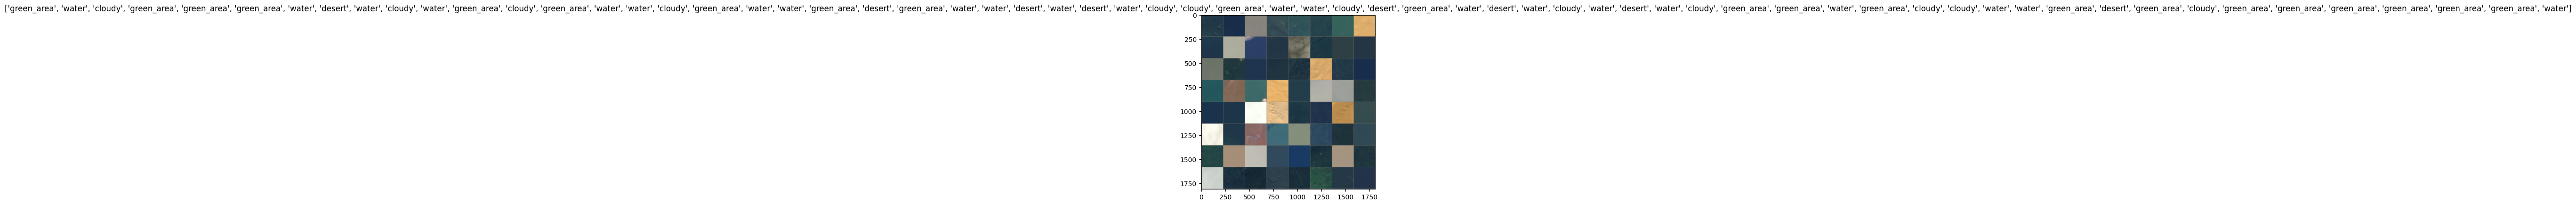

In [5]:
#Displaying Validation Images
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Validation']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


IMPORTING PRETRAINED RESNET 50 MODEL

In [6]:
import torchvision.models as models
model = models.resnet50(pretrained=True)
model.eval()

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [8]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

DEFINING MODELS TRAINING LOOP

In [9]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)



                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=30)

Epoch 1/30
----------
Training Loss: 0.9065 Acc: 0.8646
Validation Loss: 0.0917 Acc: 0.9752
Epoch 2/30
----------
Training Loss: 0.0660 Acc: 0.9762
Validation Loss: 0.3658 Acc: 0.8971
Epoch 3/30
----------
Training Loss: 0.0557 Acc: 0.9820
Validation Loss: 0.1206 Acc: 0.9539
Epoch 4/30
----------
Training Loss: 0.0446 Acc: 0.9840
Validation Loss: 0.0291 Acc: 0.9894
Epoch 5/30
----------
Training Loss: 0.0406 Acc: 0.9869
Validation Loss: 0.0300 Acc: 0.9947
Epoch 6/30
----------
Training Loss: 0.0491 Acc: 0.9838
Validation Loss: 0.0471 Acc: 0.9831
Epoch 7/30
----------
Training Loss: 0.0370 Acc: 0.9887
Validation Loss: 0.0134 Acc: 0.9973
Epoch 8/30
----------
Training Loss: 0.0207 Acc: 0.9936
Validation Loss: 0.0142 Acc: 0.9965
Epoch 9/30
----------
Training Loss: 0.0299 Acc: 0.9887
Validation Loss: 0.0383 Acc: 0.9894
Epoch 10/30
----------
Training Loss: 0.0334 Acc: 0.9878
Validation Loss: 0.0348 Acc: 0.9902
Epoch 11/30
----------
Training Loss: 0.0234 Acc: 0.9918
Validation Loss: 0.025

SAVING MODEL FOR PRUNING

In [10]:
torch.save(model.state_dict(),'model.pth')

IMPORTING PYTORCH'S PRUNING LIBRARY

In [11]:
from torch.nn.utils import prune

LOADING SAVED MODEL

In [12]:
model = models.resnet50()
model.load_state_dict(torch.load('model.pth', weights_only=True))

<All keys matched successfully>

APPLYING STRUCTURED PRUNING TO THE RESNET MODEL

In [13]:
def apply_structured_pruning(model, pruning_percentage=0.2):
  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
      print(f'Pruning layer: {name}')
      prune.ln_structured(module, name='weight',amount= pruning_percentage, n=1,  dim=0)
      prune.remove(module, 'weight')

apply_structured_pruning(model,pruning_percentage=0.2)

Pruning layer: conv1
Pruning layer: layer1.0.conv1
Pruning layer: layer1.0.conv2
Pruning layer: layer1.0.conv3
Pruning layer: layer1.0.downsample.0
Pruning layer: layer1.1.conv1
Pruning layer: layer1.1.conv2
Pruning layer: layer1.1.conv3
Pruning layer: layer1.2.conv1
Pruning layer: layer1.2.conv2
Pruning layer: layer1.2.conv3
Pruning layer: layer2.0.conv1
Pruning layer: layer2.0.conv2
Pruning layer: layer2.0.conv3
Pruning layer: layer2.0.downsample.0
Pruning layer: layer2.1.conv1
Pruning layer: layer2.1.conv2
Pruning layer: layer2.1.conv3
Pruning layer: layer2.2.conv1
Pruning layer: layer2.2.conv2
Pruning layer: layer2.2.conv3
Pruning layer: layer2.3.conv1
Pruning layer: layer2.3.conv2
Pruning layer: layer2.3.conv3
Pruning layer: layer3.0.conv1
Pruning layer: layer3.0.conv2
Pruning layer: layer3.0.conv3
Pruning layer: layer3.0.downsample.0
Pruning layer: layer3.1.conv1
Pruning layer: layer3.1.conv2
Pruning layer: layer3.1.conv3
Pruning layer: layer3.2.conv1
Pruning layer: layer3.2.conv

In [14]:
print(model.conv1.weight.shape)

torch.Size([64, 3, 7, 7])


PRINTING ZERO WEIGHTS IN THE CONV2D LAYER

In [15]:
for name,  module  in model.named_modules():
  if isinstance(module, nn.Conv2d):
    print(f'Layer {name},  Zero weights: {torch.sum(module.weight == 0)}')

Layer conv1,  Zero weights: 1911
Layer layer1.0.conv1,  Zero weights: 832
Layer layer1.0.conv2,  Zero weights: 7488
Layer layer1.0.conv3,  Zero weights: 3264
Layer layer1.0.downsample.0,  Zero weights: 3264
Layer layer1.1.conv1,  Zero weights: 3328
Layer layer1.1.conv2,  Zero weights: 7488
Layer layer1.1.conv3,  Zero weights: 3264
Layer layer1.2.conv1,  Zero weights: 3328
Layer layer1.2.conv2,  Zero weights: 7488
Layer layer1.2.conv3,  Zero weights: 3264
Layer layer2.0.conv1,  Zero weights: 6656
Layer layer2.0.conv2,  Zero weights: 29952
Layer layer2.0.conv3,  Zero weights: 13056
Layer layer2.0.downsample.0,  Zero weights: 26112
Layer layer2.1.conv1,  Zero weights: 13312
Layer layer2.1.conv2,  Zero weights: 29952
Layer layer2.1.conv3,  Zero weights: 13056
Layer layer2.2.conv1,  Zero weights: 13312
Layer layer2.2.conv2,  Zero weights: 29952
Layer layer2.2.conv3,  Zero weights: 13056
Layer layer2.3.conv1,  Zero weights: 13312
Layer layer2.3.conv2,  Zero weights: 29952
Layer layer2.3.conv

FINETUNING THE PRUNED MODEL TO REGAIN LOST ACCURACY

In [16]:

#Defining EarlyStopping
class EarlyStopping:
  def __init__(self, patience=5, verbose=False):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_loss = None

  def __call__(self,val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
    elif val_loss < self.best_loss:
      self.best_loss = val_loss
      self.counter =  0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        if self.verbose:
          print('Early stopping triggered')
          return True
        return False

In [17]:
optimizer = optim.SGD(model.parameters(), lr= 1e-4, momentum=0.9, weight_decay =0.01)

In [18]:
def train_model(model, criterion, optimizer, num_epochs=40, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it improves on validation accuracy
            if phase == 'Validation':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

                # Check for early stopping condition based on validation loss
                if early_stopping(epoch_loss):  # If early stopping returns True, stop training
                    print("Early stopping triggered!")
                    model.load_state_dict(best_model_wts)  # Restore the best model weights
                    return model  # Return the model and stop training early

    # Load best model weights if no early stopping was triggered
    model.load_state_dict(best_model_wts)
    return model

# Train the model with early stopping
model = train_model(model, criterion, optimizer, num_epochs=40)


Epoch 1/40
----------
Training Loss: 0.0318 Acc: 0.9942
Validation Loss: 0.0141 Acc: 0.9965
Epoch 2/40
----------
Training Loss: 0.0243 Acc: 0.9938
Validation Loss: 0.0156 Acc: 0.9956
Epoch 3/40
----------
Training Loss: 0.0169 Acc: 0.9973
Validation Loss: 0.0056 Acc: 1.0000
Epoch 4/40
----------
Training Loss: 0.0174 Acc: 0.9949
Validation Loss: 0.0109 Acc: 0.9956
Epoch 5/40
----------
Training Loss: 0.0157 Acc: 0.9973
Validation Loss: 0.0115 Acc: 0.9965
Epoch 6/40
----------
Training Loss: 0.0167 Acc: 0.9967
Validation Loss: 0.0076 Acc: 0.9982
Epoch 7/40
----------
Training Loss: 0.0164 Acc: 0.9956
Validation Loss: 0.0056 Acc: 1.0000
Epoch 8/40
----------
Training Loss: 0.0218 Acc: 0.9947
Validation Loss: 0.0110 Acc: 0.9965
Early stopping triggered
Early stopping triggered!


VISUALIZING TRAINING LOGS ONLY ON 8 EPOCHS

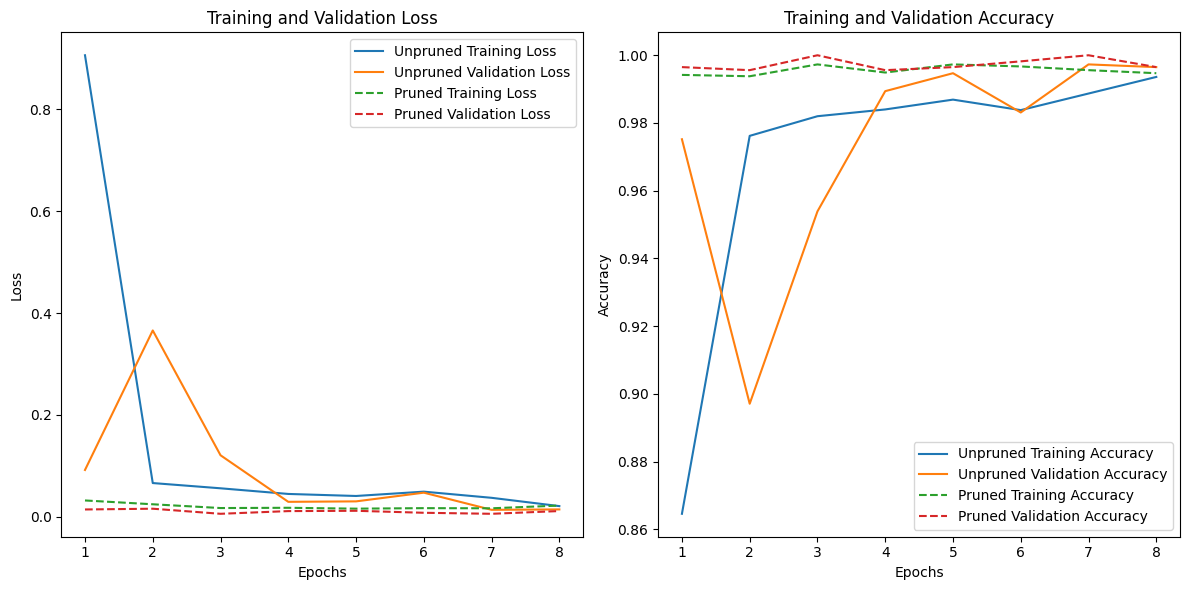

In [19]:
import matplotlib.pyplot as plt

# Example data for unpruned model
unpruned_train_loss = [0.9065, 0.0660, 0.0557, 0.0446, 0.0406, 0.0491, 0.0370, 0.0207]
unpruned_val_loss = [0.0917, 0.3658, 0.1206, 0.0291, 0.0300, 0.0471, 0.0134, 0.0142]
unpruned_train_acc = [0.8646, 0.9762, 0.9820, 0.9840, 0.9869, 0.9838, 0.9887, 0.9936]
unpruned_val_acc = [0.9752, 0.8971, 0.9539, 0.9894, 0.9947, 0.9831, 0.9973, 0.9965]

# Example data for pruned model
pruned_train_loss = [0.0318, 0.0243, 0.0169, 0.0174, 0.0157, 0.0167, 0.0164, 0.0218]
pruned_val_loss = [0.0141, 0.0156, 0.0056, 0.0109, 0.0115, 0.0076, 0.0056, 0.0110]
pruned_train_acc = [0.9942, 0.9938, 0.9973, 0.9949, 0.9973, 0.9967, 0.9956, 0.9947]
pruned_val_acc = [0.9965, 0.9956, 1.0000, 0.9956, 0.9965, 0.9982, 1.0000, 0.9965]

# Plotting
epochs_unpruned = range(1, len(unpruned_train_loss) + 1)
epochs_pruned = range(1, len(pruned_train_loss) + 1)

plt.figure(figsize=(12, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(epochs_unpruned, unpruned_train_loss, label='Unpruned Training Loss')
plt.plot(epochs_unpruned, unpruned_val_loss, label='Unpruned Validation Loss')
plt.plot(epochs_pruned, pruned_train_loss, label='Pruned Training Loss', linestyle='--')
plt.plot(epochs_pruned, pruned_val_loss, label='Pruned Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(epochs_unpruned, unpruned_train_acc, label='Unpruned Training Accuracy')
plt.plot(epochs_unpruned, unpruned_val_acc, label='Unpruned Validation Accuracy')
plt.plot(epochs_pruned, pruned_train_acc, label='Pruned Training Accuracy', linestyle='--')
plt.plot(epochs_pruned, pruned_val_acc, label='Pruned Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

